In [ ]:
#importare librarii
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import re
import datetime
import time
from datetime import timedelta, datetime
import holidays
from meteostat import Point, Daily

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Explorare date

In [ ]:
#import CSV
path = '/dataset/df_complete.csv'
data_new = pd.read_csv(path)

In [ ]:
data_new.describe()

,sequence,value,order_group_id,sales_channel_id,interest_value
count,4.378200e+04,4.385100e+04,43687.000000,8044.000000,7.831000e+03
mean,2.238929e+07,3.670971e+06,5.086593,3.084535,9.751159e+02
std,9.554380e+07,1.962074e+07,6.950791,7.630489,3.044461e+04
min,9.027100e+04,0.000000e+00,1.000000,1.000000,0.000000e+00
25%,5.938465e+05,1.023950e+04,1.000000,1.000000,0.000000e+00
50%,1.327774e+06,2.809500e+04,4.000000,1.000000,0.000000e+00
75%,7.578648e+06,3.631090e+05,8.000000,1.000000,0.000000e+00
max,2.000017e+09,9.651000e+08,101.000000,82.000000,2.011628e+06


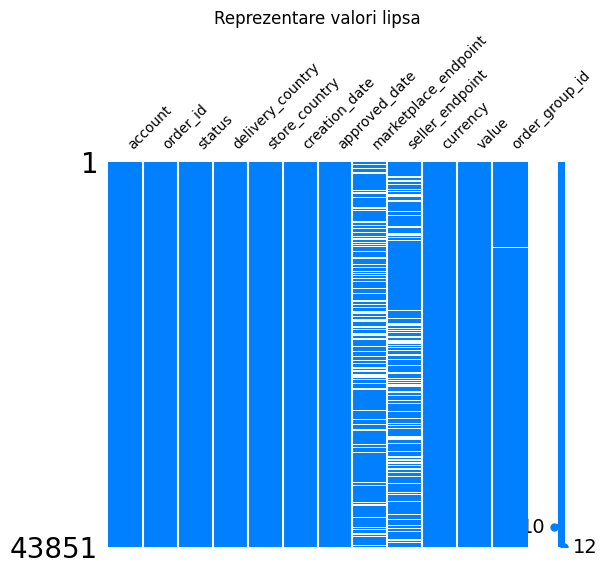

In [ ]:
data_msno = data_new.copy()
data_msno.drop(columns = ['id','sequence','delivery_state','external_marketplace_name','internal_marketplace_account','marketplace_order_id','internal_certified_seller_account','seller_order_id','updated_at','sales_channel_id','interest_value'],inplace=True)
msno.matrix(data_msno,figsize=(6,5),color=(0,0.5,1))
plt.xticks(fontsize=10)
plt.title('Reprezentare valori lipsa')
plt.show()

In [ ]:
data_msno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43851 entries, 0 to 43850
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   account               43851 non-null  object 
 1   order_id              43851 non-null  object 
 2   status                43849 non-null  object 
 3   delivery_country      43851 non-null  object 
 4   store_country         43851 non-null  object 
 5   creation_date         43851 non-null  object 
 6   approved_date         43851 non-null  object 
 7   marketplace_endpoint  32664 non-null  object 
 8   seller_endpoint       34397 non-null  object 
 9   currency              43851 non-null  object 
 10  value                 43851 non-null  int64  
 11  order_group_id        43687 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 4.0+ MB


In [ ]:
data_msno.describe()

,value,order_group_id
count,4.385100e+04,43687.000000
mean,3.670971e+06,5.086593
std,1.962074e+07,6.950791
min,0.000000e+00,1.000000
25%,1.023950e+04,1.000000
50%,2.809500e+04,4.000000
75%,3.631090e+05,8.000000
max,9.651000e+08,101.000000


In [ ]:
data_new = data_new[(data_new['status'] == 'invoice') | (data_new['status'] == 'invoiced')]

In [ ]:
#Date lipsa
total = data_new.isnull().sum().sort_values(ascending = False)
percent = (data_new.isnull().sum()/len(data_new)*100).sort_values(ascending = False)
missing_data = pd.concat([total,percent], axis = 1,keys = ['Total','Percentage [%]'])

In [ ]:
#stergere valori cu date lipsa > 30%
percent_missing_data = data_new.isnull().sum()/len(data_new)*100
colsToDrop = data_new.columns[percent_missing_data > 30]
data_new.drop(columns=colsToDrop,inplace=True)

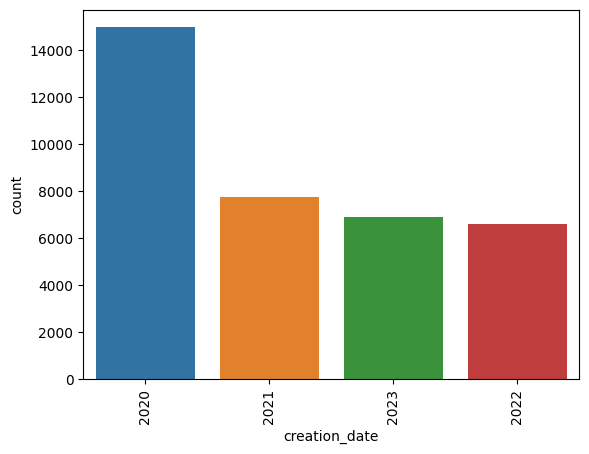

In [ ]:
#grafic nr observatii anuale
sns.countplot(x=pd.to_datetime(data_new['creation_date']).dt.year, order=pd.to_datetime(data_new['creation_date']).dt.year.value_counts(ascending=False).index)
plt.xticks(rotation=90)
plt.show()

In [ ]:
data_new = data_new[pd.to_datetime(data_new['creation_date']).dt.year < 2022]

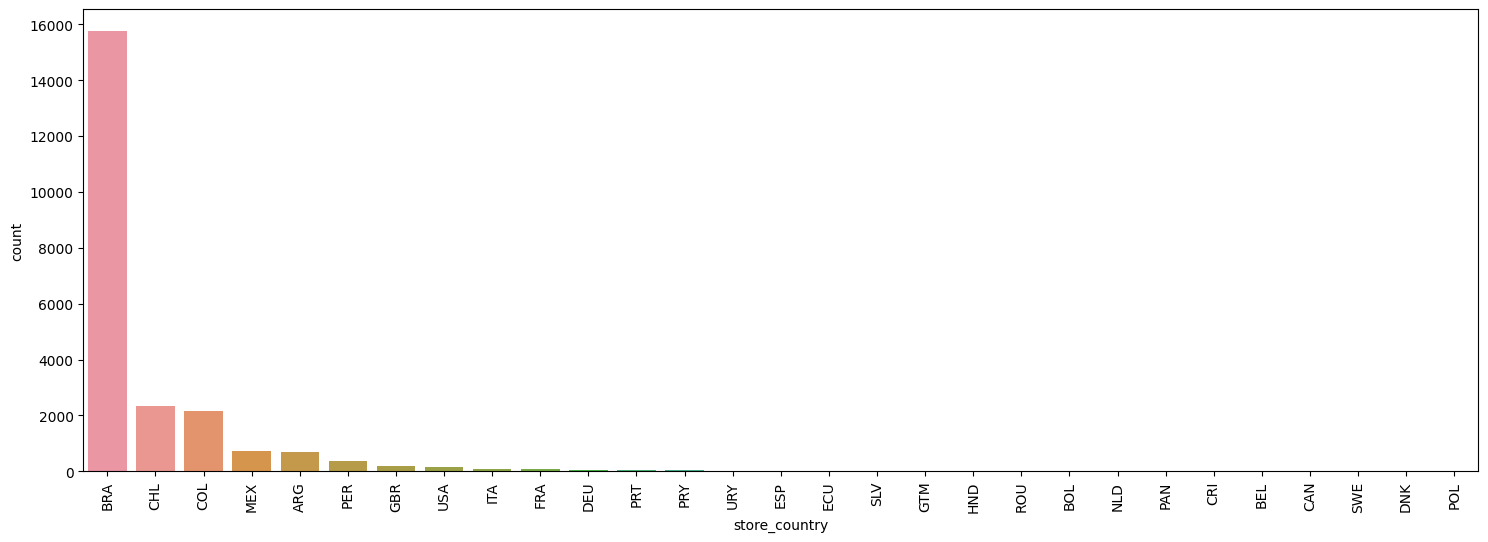

In [ ]:
#reprezentare a datelor pe tari
plt.figure(figsize=(18,6))
sns.countplot(x= data_new['store_country'], order =data_new['store_country'].value_counts(ascending=False).index)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#eliminarea observatiilor din tarile cu date nesemnificative
counts = data_new['store_country'].value_counts(normalize=True).mul(100)
data_new = data_new[data_new['store_country'].isin(counts[counts > 3].index)]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


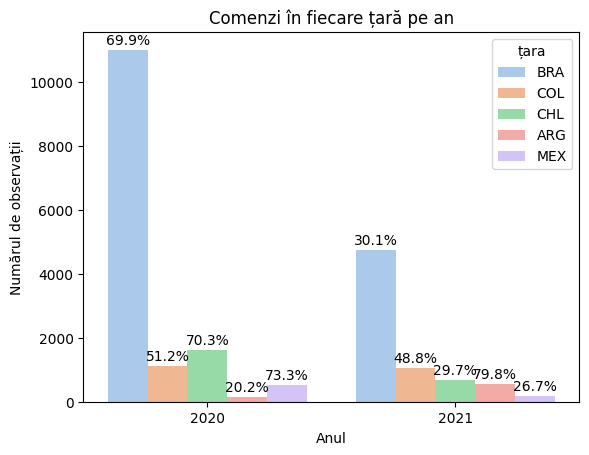

In [ ]:
data_new['year'] = pd.to_datetime(data_new['creation_date']).dt.year
fig,ax = plt.subplots()
sns.countplot(data_new, x='year', hue = 'store_country', palette='pastel')
arr_len = [len(data_new[data_new['store_country'] == country]) for country in data_new['store_country'].unique()]
arr_len_repeated = [item for item in arr_len for _ in range(2)]
j = 0
for i in ax.patches:
  height = i.get_height()
  percentage = height / arr_len_repeated[j] * 100
  ax.annotate(f'{percentage:.1f}%',(i.get_x() + i.get_width() / 2, height), ha='center', va='center', xytext=(0, 7), textcoords='offset points')
  j += 1
ax.set_xlabel('Anul')
ax.set_ylabel('Numărul de observații')
ax.set_title('Comenzi în fiecare țară pe an')
plt.legend(title='țara')
plt.show()
data_new.drop(columns = ['year'], inplace = True)

In [ ]:
data_new = data_new[data_new['store_country'] != 'ARG']

# Ingineria trasaturilor

In [ ]:
#stergere valori lipsa - numar mic
data_new.dropna(subset =['order_group_id'], inplace = True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Transformare Value-logaritmare


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



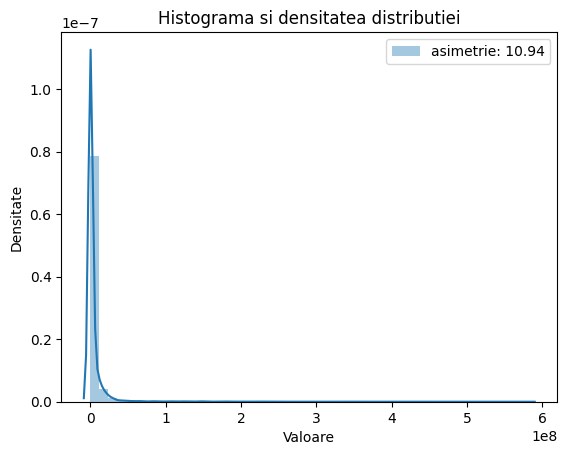

In [ ]:
#distributia valorii de prezis
sns.distplot(data_new['value'], label = 'asimetrie: ' + str(np.round(data_new['value'].skew(),2)))
plt.title('Histograma si densitatea distributiei')
plt.xlabel('Valoare')
plt.ylabel('Densitate')
plt.legend()
plt.show()

In [ ]:
#medie, min, max pentru fiecare tara
for country in data_new['store_country'].unique():
  print(country)
  print(data_new[data_new['store_country'] == country]['value'].describe())
  print('///////////////////')

BRA
count    1.575800e+04
mean     5.098703e+04
std      9.352381e+04
min      0.000000e+00
25%      8.890750e+03
50%      1.924950e+04
75%      4.610600e+04
max      2.308531e+06
Name: value, dtype: float64
///////////////////
COL
count    2.174000e+03
mean     3.437226e+07
std      5.675694e+07
min      3.442000e+05
25%      7.812900e+06
50%      1.508625e+07
75%      2.927392e+07
max      5.810376e+08
Name: value, dtype: float64
///////////////////
CHL
count    2.319000e+03
mean     8.294975e+06
std      1.063684e+07
min      9.910000e+04
25%      3.399050e+06
50%      5.897000e+06
75%      1.019735e+07
max      3.144960e+08
Name: value, dtype: float64
///////////////////
MEX
count    7.110000e+02
mean     5.840296e+05
std      7.692984e+05
min      5.800000e+03
25%      1.299000e+05
50%      3.148000e+05
75%      6.999000e+05
max      6.744905e+06
Name: value, dtype: float64
///////////////////


In [ ]:
data_new['store_country'].value_counts()

BRA    15758
CHL     2319
COL     2174
MEX      711
Name: store_country, dtype: int64

In [ ]:
#valorile din Columbia sunt foarte mari => le scot pentru a nu influenta predictia si a face distributia si mai asimetrica
data_new[data_new['value'] < 1.5e7]['store_country'].value_counts()

BRA    15758
CHL     2042
COL     1081
MEX      711
Name: store_country, dtype: int64

In [ ]:
data_new = data_new[data_new['store_country']!='COL']

In [ ]:
data_new = data_new[(1 < data_new['value']) & (data_new['value'] < 1e7)]

In [ ]:
data_nolog = data_new.copy()

In [ ]:
#aplicare functie de logaritmare pentru Value
transformer = FunctionTransformer(func = np.log1p, inverse_func = np.expm1)
data_new['value']=transformer.transform(data_new['value'])


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



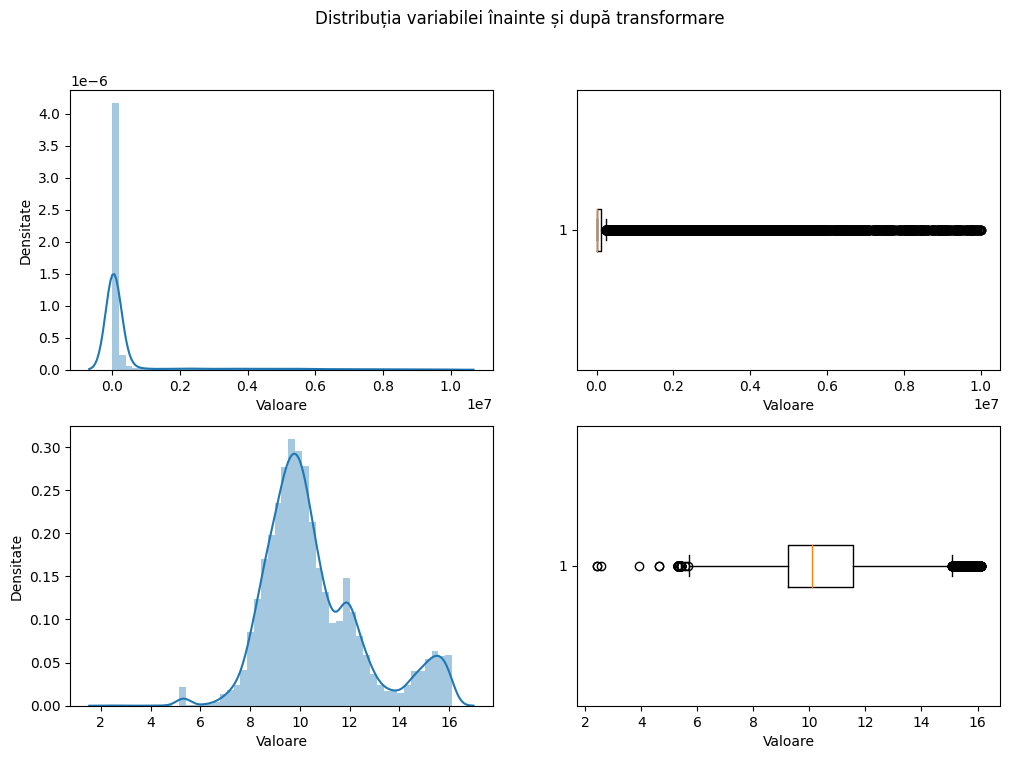

In [ ]:
#grafice cu logaritmare si fara
plt.figure(figsize=(12,8))
plt.suptitle('Distribuția variabilei înainte și după transformare')
plt.subplot(221)
sns.distplot(data_nolog['value'])
plt.xlabel('Valoare')
plt.ylabel('Densitate')

plt.subplot(223)
sns.distplot(data_new['value'])
plt.xlabel('Valoare')
plt.ylabel('Densitate')

plt.subplot(222)
plt.boxplot(data_nolog['value'], vert=False)
plt.xlabel('Valoare')

plt.subplot(224)
plt.boxplot(data_new['value'], vert=False)
plt.xlabel('Valoare')


plt.show()

In [ ]:
del data_nolog

In [ ]:
data_new['store_country'].value_counts()

BRA    15742
CHL     1720
MEX      711
Name: store_country, dtype: int64

In [ ]:
for country in data_new['store_country'].unique():
    country_data = data_new[data_new['store_country'] == country]
    Q1 = country_data['value'].quantile(0.25)
    Q3 = country_data['value'].quantile(0.75)
    IQR = Q3 - Q1
    range_min = Q1 - 1.5 * IQR
    range_max = Q3 + 1.5 * IQR
    country_data = country_data[(country_data['value'] < range_min) | (country_data['value'] > range_max)]
    print(country_data.index)
    data_new.drop(country_data.index,inplace = True)

Int64Index([  208,   681,   755,   921,  1187,  1541,  1580,  1620,  1780,
             2212,
            ...
            42910, 43121, 43211, 43246, 43348, 43384, 43430, 43712, 43748,
            43766],
           dtype='int64', length=208)
Int64Index([ 8778, 26034, 26884, 28698, 29083, 31392, 33817, 34254, 39981,
            39999, 40137, 40891, 41076, 42069, 42295, 42334],
           dtype='int64')
Int64Index([26936, 32617], dtype='int64')


In [ ]:
data_new['store_country'].value_counts()

BRA    15534
CHL     1704
MEX      709
Name: store_country, dtype: int64

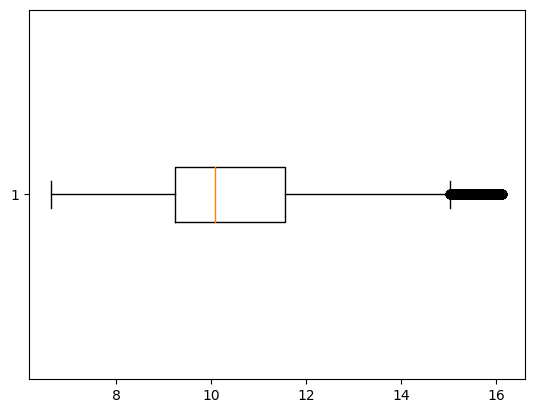

In [ ]:
# fara valori extreme
fig, ax = plt.subplots()
ax.boxplot(data_new['value'], vert=False, showfliers=True)
plt.show()

Adaugare de noi trasaturi

In [ ]:
def three_alpha(string):
  return string[:3].isalpha()
data_new['order_seller'] = data_new['order_id'].apply(three_alpha)

In [ ]:
data_new['order_seller'].value_counts()

False    13440
True      4507
Name: order_seller, dtype: int64

In [ ]:
def extract_letters(word):
    letters_only = re.sub(r'[^a-zA-Z]', '', word)
    return letters_only

In [ ]:
data_new['account_group'] = data_new['account'].apply(extract_letters)

In [ ]:
data_new['approved_date'] = pd.to_datetime(data_new['approved_date'])
data_new['creation_date'] = pd.to_datetime(data_new['creation_date'])

In [ ]:
data_new['day'] = data_new['creation_date'].dt.day
data_new['month'] = data_new['creation_date'].dt.month
data_new['year'] = data_new['creation_date'].dt.year
data_new['week_number'] = data_new['creation_date'].dt.isocalendar().week
data_new['quarter'] = data_new['creation_date'].dt.quarter
#0 luni si 6 duminica
data_new['day_of_week'] = data_new['creation_date'].dt.weekday

In [ ]:
data_new['waiting_approval_day'] = data_new['approved_date'] - data_new['creation_date']

In [ ]:
data_new['waiting_approval_day'] = data_new['waiting_approval_day'].apply(lambda x:str(x).split()[0])
data_new['waiting_approval_day'] = data_new['waiting_approval_day'].astype(int)

In [ ]:
data_new.drop(columns=['id','sequence','delivery_country','delivery_state','marketplace_endpoint','seller_endpoint','updated_at','currency','status'],inplace=True)

In [ ]:
#consider pandemie din 1 martie 2020-31 decembrie 2021
pandemic_start_date = pd.Timestamp(2020, 3, 1)
pandemic_end_date = pd.Timestamp(2021, 12 , 31)

In [ ]:
data_new['is_pandemic'] = data_new['creation_date'].apply(lambda x: True if pandemic_start_date <= x <= pandemic_end_date else False)

In [ ]:
country_names = data_new['store_country'].unique()

In [ ]:
country_codes_dict = {
    'ARG':'AR',
    'BRA':'BR',
    'CHL':'CL',
    'COL':'CO',
    'MEX':'MX',
    'URY':'UY',
    'USA':'US',
    'ECU':'EC',
    'PER':'PE',
    'SLV':'SK',
    'ITA':'IT',
    'BOL':'BO',
    'PRY':'PY',
    'ROU':'RO',
    'DOM':'DO',
    'ESP':'ES',
    'HND':'NL',
    'GBR':'GB',
    'PRT':'PT',
    'FRA':'FR',
    'DEU':'DE',
}

In [ ]:
def mark_holidays(row):
    country_code = row['store_country']
    country_name = country_codes_dict[country_code]
    country_holidays = getattr(holidays, country_name)()
    creation_date = row['creation_date']

    # Check if the creation date is a holiday
    if (creation_date == datetime(2020, 11, 27) or
            creation_date == datetime(2021, 11, 26)):
        row['is_holiday'] = True
    else:
        # Check the next 7 days for holidays
        for days in range(0, 8):
            sale_date = creation_date + timedelta(days=days)
            is_holiday = sale_date in country_holidays
            if is_holiday:
                row['is_holiday'] = True
                break
        else:
            row['is_holiday'] = False
    return row

data_new = data_new.apply(mark_holidays, axis=1)


In [ ]:
data_new['is_holiday'] = data_new['is_holiday'].astype(int)
data_new['is_pandemic'] = data_new['is_pandemic'].astype(int)
data_new['order_seller'] = data_new['order_seller'].astype(int)

In [ ]:
#temperatura si umiditate
start = datetime(2020, 1, 1)
end = datetime(2022, 1, 1)

Rio_de_Janeiro = Point(-22.908333, -43.196388)
data_bra = Daily(Rio_de_Janeiro, start, end)
data_bra = data_bra.fetch()
data_bra = data_bra[['tavg','prcp']]
data_bra['store_country'] = 'BRA'
data_bra = data_bra.reset_index()

Mexico_City = Point(19.432608, -99.133209)
data_mex = Daily(Mexico_City, start, end)
data_mex = data_mex.fetch()
data_mex = data_mex[['tavg','prcp']]
data_mex['store_country'] = 'MEX'
data_mex = data_mex.reset_index()

Santiago = Point(-33.447487, -70.673676)
data_chl = Daily(Santiago, start, end)
data_chl = data_chl.fetch()
data_chl = data_chl[['tavg','prcp']]
data_chl['store_country'] = 'CHL'
data_chl = data_chl.reset_index()

In [ ]:
#dataframe cu tabel, temperatura, precipitatii si tara
data_all = pd.DataFrame()
list_meteo = [data_bra,data_chl,data_mex]
for data_country in list_meteo:
    data_all = pd.concat([data_all,data_country])
    del data_country

In [ ]:
data_new = pd.merge(data_new, data_all, left_on=['store_country', 'creation_date'], right_on=['store_country','time'])
data_new.drop(columns=['time'],inplace = True)
del data_all

In [ ]:
#ffill pentru datele lipsa
data_new['prcp'] = data_new['prcp'].fillna(method='ffill')

In [ ]:
# Incarcare PPP dataset
ppp_data = pd.read_csv("/dataset/ppp_dataset.csv")

# inner join intre data_new si ppp_data
data_new = pd.merge(data_new, ppp_data, left_on=["store_country", "year"],right_on=['LOCATION','TIME'])
data_new = data_new.rename(columns={'Value': 'ppp_value'})
del ppp_data

In [ ]:
data_new['month_year'] = pd.to_datetime(data_new['year'].astype(str) + '-' + data_new['month'].astype(str), format='%Y-%m')
data_new['month_year'] = data_new['month_year'].dt.to_period('M')
data_new['month_year'] = data_new['month_year'].dt.strftime('%Y-%m')

In [ ]:
# Incarcare rata inflatie
inflation_data = pd.read_csv("/dataset/cpi.csv")

# inner join intre data_new si inflation_rate
data_new = pd.merge(data_new, inflation_data, left_on=["store_country", "month_year"],right_on=['LOCATION','TIME'])
data_new = data_new.rename(columns={'Value':  'cpi_value'})
del inflation_data

In [ ]:
# Incarcare rata de somaj
uemployment_data = pd.read_csv("/dataset/unemplyment.csv")

# inner join data_new, unemployment data
data_new = pd.merge(data_new, uemployment_data, left_on=["store_country", "month_year"],right_on=['LOCATION','TIME'])
data_new = data_new.rename(columns={'Value':  'unemployment_value'})
del uemployment_data

# Vizualizari

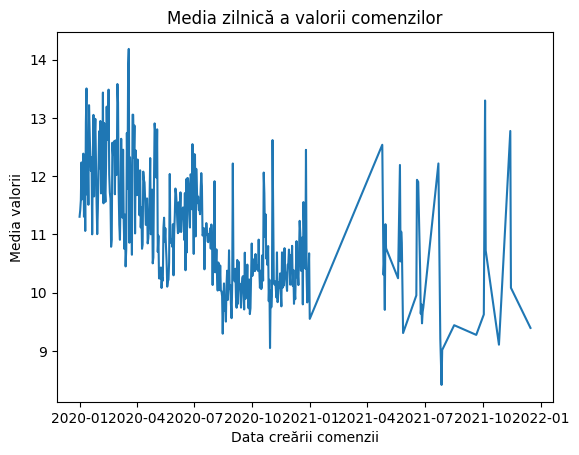

In [ ]:
# grupare pe zi si calcularea mediei
df_grouped_day = data_new.groupby('creation_date')['value'].mean()

# convert Series -> DataFrame
df_grouped_day = df_grouped_day.to_frame().reset_index()

sns.lineplot(data=df_grouped_day, x="creation_date", y="value")
plt.title("Media zilnică a valorii comenzilor")
plt.xlabel('Data creării comenzii')
plt.ylabel('Media valorii')
plt.show()
del df_grouped_day

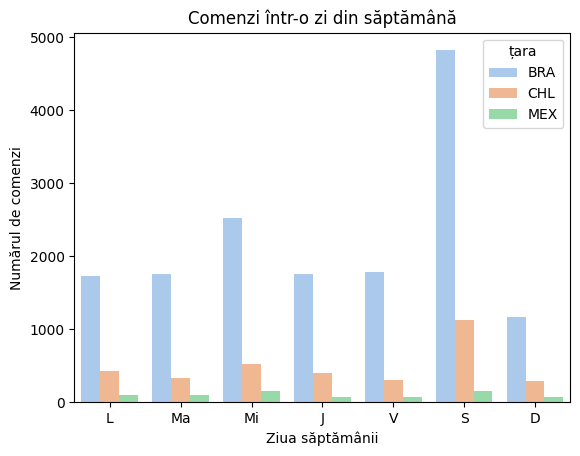

In [ ]:
# Comenzi intr-o anumita zi din saptamana
fig,ax = plt.subplots()
sns.countplot(data_new, x='day_of_week', hue = 'store_country', palette='pastel')
day_of_week_label = ['L', 'Ma', 'Mi', 'J', 'V', 'S', 'D']
ax.set_xticklabels(day_of_week_label)
ax.set_xlabel('Ziua săptămânii')
ax.set_ylabel('Numărul de comenzi')
ax.set_title('Comenzi într-o zi din săptămână')
plt.legend(title='țara')
plt.show()

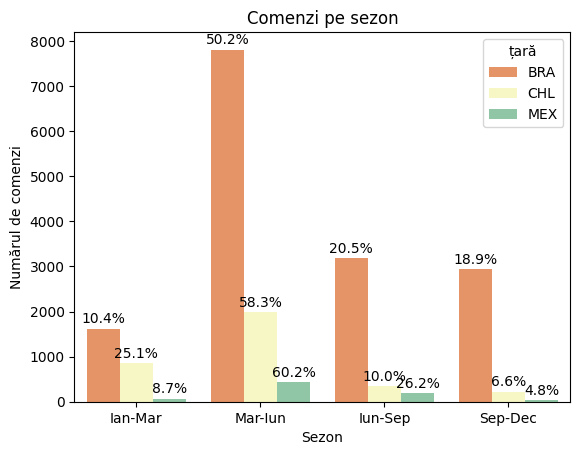

In [ ]:
fig,ax = plt.subplots()
sns.countplot(data_new, x='quarter', hue = 'store_country', palette='Spectral')
quarter_label = ['Ian-Mar', 'Mar-Iun', 'Iun-Sep', 'Sep-Dec']
ax.set_xticklabels(quarter_label)
ax.set_xlabel('Sezon')
ax.set_ylabel('Numărul de comenzi')
ax.set_title('Comenzi pe sezon')
plt.legend(title='țară')
arr_len = [len(data_new[data_new['store_country'] == country]) for country in data_new['store_country'].unique()]
arr_len_repeated = [item for item in arr_len for _ in range(4)]
j = 0
for i in ax.patches:
  height = i.get_height()
  percentage = height / arr_len_repeated[j] * 100
  ax.annotate(f'{percentage:.1f}%',(i.get_x() + i.get_width() / 2, height), ha='center', va='center', xytext=(0, 7), textcoords='offset points')
  j += 1
plt.show()

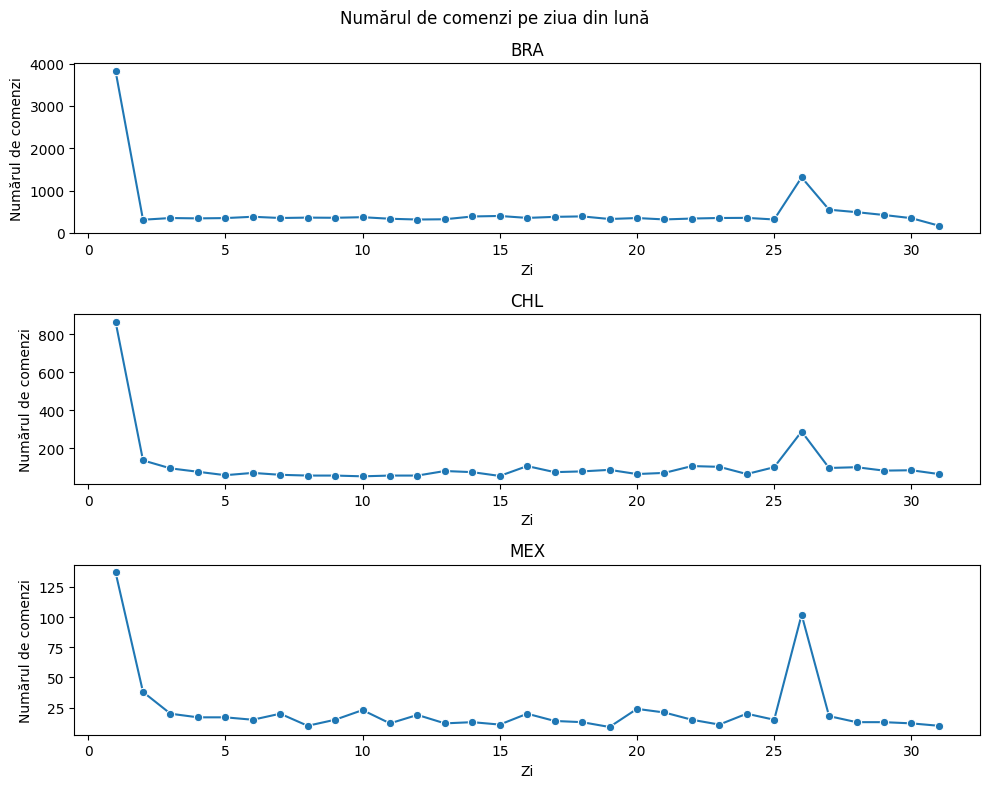

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
group_counts = data_new.groupby(['store_country', 'day']).size().reset_index(name='count')

for i, tara in enumerate(group_counts['store_country'].unique()):
    ax = axes[i]
    data_tara = group_counts[group_counts['store_country'] == tara]
    sns.lineplot(data=data_tara, x='day', y='count', ax=ax, marker = 'o')

    ax.set_xlabel('Zi')
    ax.set_ylabel('Numărul de comenzi')
    ax.set_title(f'{tara}')
fig.suptitle('Numărul de comenzi pe ziua din lună')
plt.tight_layout()
plt.show()
del group_counts

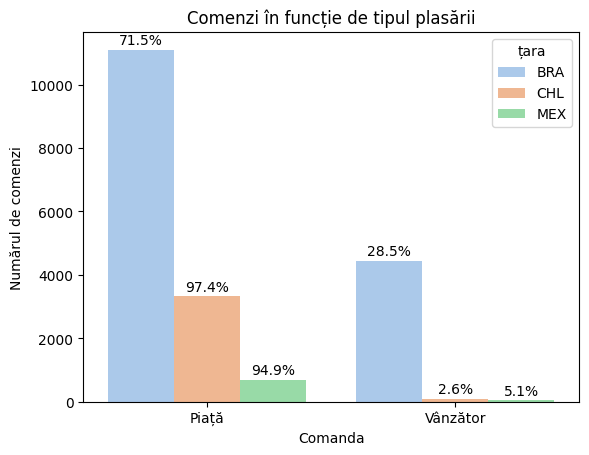

In [ ]:
# Numarul comenzi in functie de tipul plasarii
fig,ax = plt.subplots()
sns.countplot(data_new, x='order_seller', hue = 'store_country', palette='pastel')
seller_label = ['Piață', 'Vânzător']
ax.set_xticklabels(seller_label)
arr_len = [len(data_new[data_new['store_country'] == country]) for country in data_new['store_country'].unique()]
arr_len_repeated = [item for item in arr_len for _ in range(2)]
j = 0
for i in ax.patches:
  height = i.get_height()
  percentage = height / arr_len_repeated[j] * 100
  ax.annotate(f'{percentage:.1f}%',(i.get_x() + i.get_width() / 2, height), ha='center', va='center', xytext=(0, 7), textcoords='offset points')
  j += 1
ax.set_xlabel('Comanda')
ax.set_ylabel('Numărul de comenzi')
ax.set_title('Comenzi în funcție de tipul plasării')
plt.legend(title='țara')
plt.show()

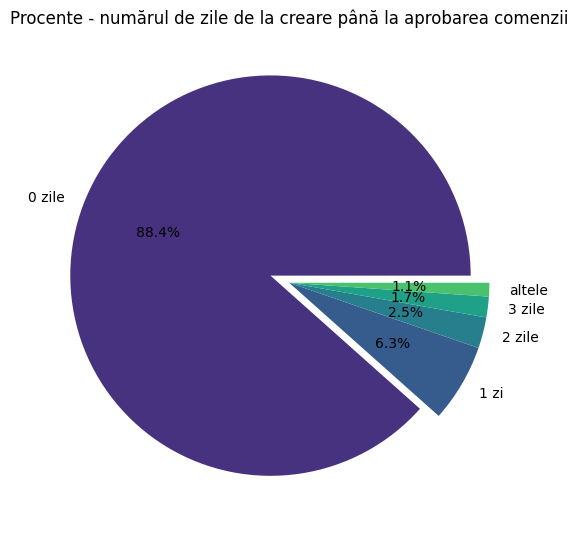

In [ ]:
fig, axes = plt.subplots( figsize=(6.5, 6.5))
counts = data_new['waiting_approval_day'].value_counts()
percentages = counts * 100 / counts.sum()
percentages_wanted = percentages[percentages > 1]
percentages_wanted['others'] = percentages[percentages <= 1].sum()
zeros_vector = [0] * len(percentages_wanted)
zeros_vector[0] = 0.1
zeros_labels = [0] * len(percentages_wanted)
zeros_labels[0], zeros_labels[1], zeros_labels[2], zeros_labels[3], zeros_labels[4] = '0 zile','1 zi', '2 zile', '3 zile', 'altele'
plt.pie(percentages_wanted, autopct='%1.1f%%', explode = zeros_vector, labels = zeros_labels, colors = sns.color_palette('viridis'))
plt.title('Procente - numărul de zile de la creare până la aprobarea comenzii')
plt.show()

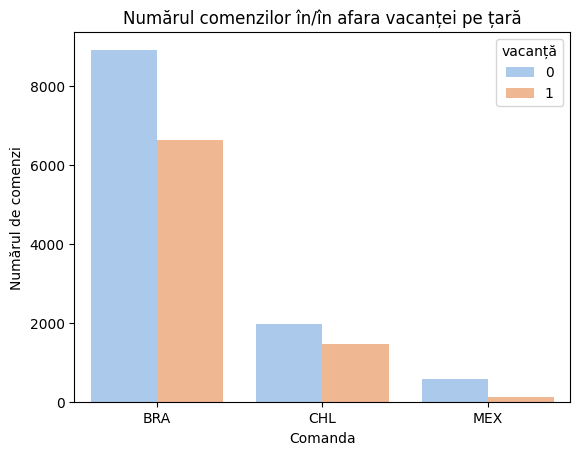

In [ ]:
fig,ax = plt.subplots()
sns.countplot(data_new, x='store_country', hue = 'is_holiday', palette='pastel')
ax.set_xlabel('Comanda')
ax.set_ylabel('Numărul de comenzi')
ax.set_title('Numărul comenzilor în/în afara vacanței pe țară')
plt.legend(title='vacanță')
plt.show()

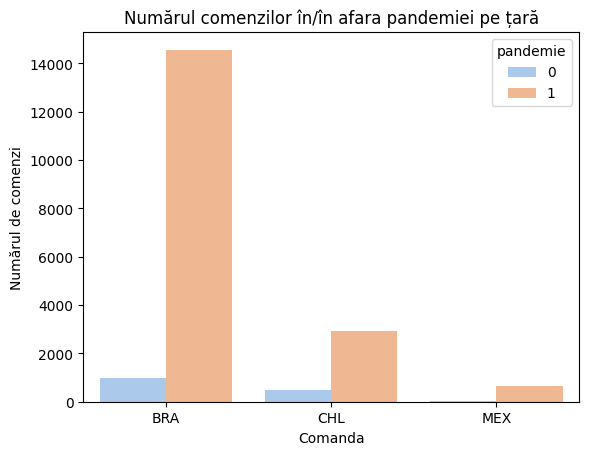

In [ ]:
fig,ax = plt.subplots()
sns.countplot(data_new, x='store_country', hue = 'is_pandemic', palette='pastel')
ax.set_xlabel('Comanda')
ax.set_ylabel('Numărul de comenzi')
ax.set_title('Numărul comenzilor în/în afara pandemiei pe țară')
plt.legend(title='pandemie')
plt.show()

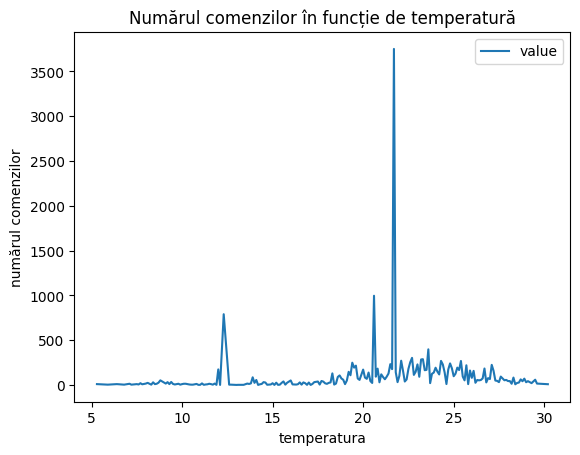

In [ ]:
temperature_values = pd.pivot_table(data_new, values = 'value', index= 'tavg', aggfunc='count')
temperature_values.plot()
plt.xlabel('temperatura')
plt.ylabel('numărul comenzilor')
plt.title('Numărul comenzilor în funcție de temperatură')
plt.show()

Codarea datelor categorice

In [ ]:
from sklearn.preprocessing import LabelEncoder
data_new['account_encoded'] = LabelEncoder().fit_transform(data_new.account)
data_new['account_group'] = LabelEncoder().fit_transform(data_new.account_group)

In [ ]:
data_new = pd.get_dummies(data_new, columns = ['store_country'])

In [ ]:
data_new.drop(columns = ['account','LOCATION_x','TIME_x','LOCATION','TIME','order_id','creation_date','approved_date','LOCATION_y','INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME_y','Flag Codes','month_year'],inplace=True)

In [ ]:
#data_new.to_csv('/content/drive/MyDrive/ml_dataset.csv',index=False)

# Selectarea trasaturilor

In [ ]:
X_train, y_train = data_new[data_new['year'] == 2020].drop('value', axis = 1),data_new[data_new['year']==2020]['value']
X_test, y_test = data_new[data_new['year'] == 2021].drop('value', axis = 1),data_new[data_new['year']==2021]['value']

Corelatie

<Axes: >

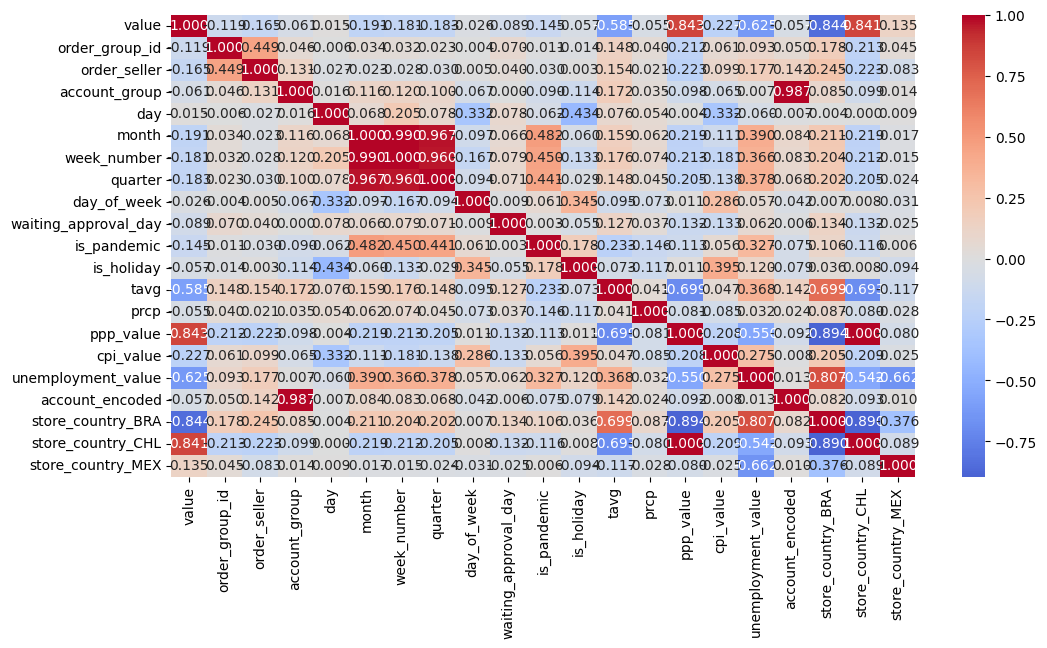

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(data_new.drop('year',axis=1).corr(method = 'pearson'), cmap="coolwarm", annot=True, center=0, ax=ax, fmt=".3f")

In [ ]:
def drop_correlation(X_train, X_test, threshold):
  set_corr = set()
  corr_matrix_pearson = X_train.corr(method = 'pearson')
  for i in range(len(corr_matrix_pearson.columns)):
    for j in range(i):
      if abs(corr_matrix_pearson.iloc[i,j]) > threshold:
        set_corr.add(corr_matrix_pearson.columns[i])
  X_train.drop(columns = list(set_corr),inplace = True)
  X_test.drop(columns = list(set_corr),inplace = True)
  fig, ax = plt.subplots(figsize=(12,6))
  sns.heatmap(X_train.drop('year',axis=1).corr(method = 'pearson'), cmap="coolwarm", annot=True, center=0, ax=ax, fmt=".3f")
  plt.show()

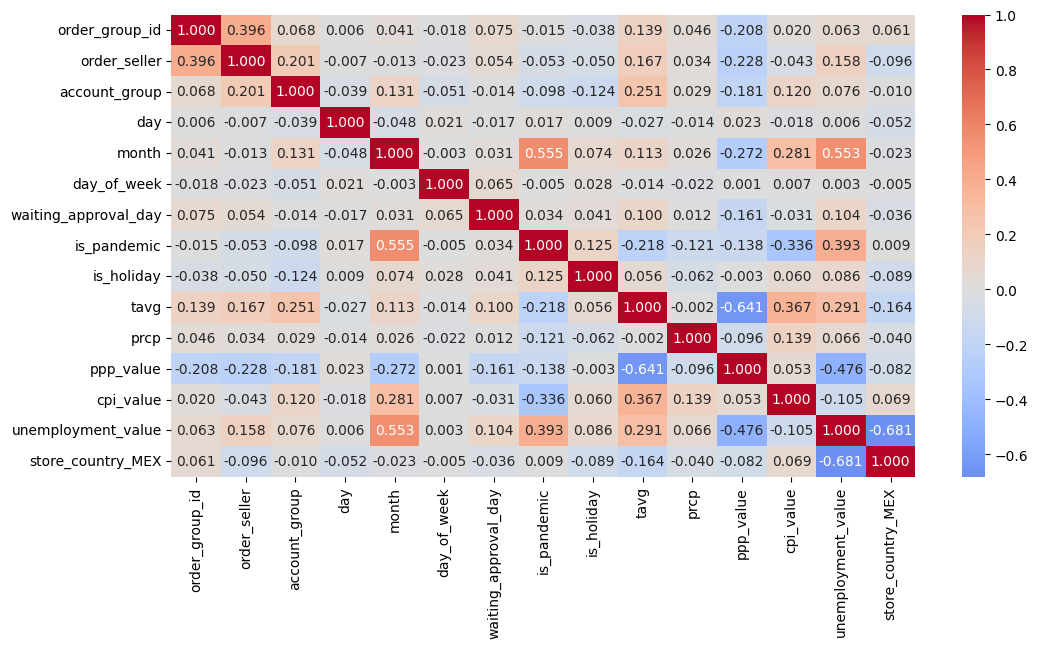

In [ ]:
drop_correlation(X_train, X_test, 0.8)

# Antrenarea si testarea modelelor

In [ ]:
def model(model,scaler_name, model_name):
  pipeline = make_pipeline(scaler_name, model)

  pipeline.fit(X_train, y_train)
  y_pred_log = pipeline.predict(X_test)

  y_pred_org = transformer.inverse_transform(y_pred_log)
  y_test_org = transformer.inverse_transform(y_test)

  rmse = np.sqrt(mean_squared_error(y_test_org, y_pred_org))
  r2 = round(r2_score(y_test_org, y_pred_org),3)
  mae = mean_absolute_error(y_test_org, y_pred_org)
  rmse_norm = np.sqrt(mean_squared_error(y_test_org, y_pred_org))/np.mean(y_test_org)

  model_scores = pd.DataFrame(columns=['Model', 'RMSE', 'RMSE_norm','R2','MAE'])
  model_scores.loc[len(model_scores)] = [model_name, rmse, rmse_norm, r2, mae]

  print(model_name, ' Raport:')
  print('RMSE: ', rmse)
  print('RMSE_norm', rmse_norm)
  print('R2: ',r2)
  print('MAE:', mae)
  return model_scores

In [ ]:
all = pd.DataFrame(columns=['Model', 'RMSE', 'RMSE_norm', 'R2','MAE'])

In [ ]:
lr=LinearRegression()
all = pd.concat([all,model(lr, None,'Linear Regression')], ignore_index= True)

Linear Regression  Raport:
RMSE:  1090388.7635148847
RMSE_norm 1.2959188146103102
R2:  0.707
MAE: 415105.7447284416


In [ ]:
rf=RandomForestRegressor(n_estimators = 500)
all = pd.concat([all,model(rf, None,'Random Forest Regressor')], ignore_index= True)

Random Forest Regressor  Raport:
RMSE:  937659.7481603733
RMSE_norm 1.1144015327403045
R2:  0.784
MAE: 351855.19039064663


In [ ]:
xgbr_model=xgb.XGBRegressor( gamma = 1,n_estimators = 5000 ,max_depth = 5, learning_rate = 0.001)
all = pd.concat([all,model(xgbr_model, None,'Extreme Gradient Boosting Regressor')], ignore_index= True)

Extreme Gradient Boosting Regressor  Raport:
RMSE:  966852.98450072
RMSE_norm 1.1490974737649244
R2:  0.77
MAE: 346065.7658656773


In [ ]:
kneighbour = KNeighborsRegressor(n_neighbors = 8)
all = pd.concat([all,model(kneighbour, StandardScaler(),'KNeighbors Regressor')], ignore_index= True)

KNeighbors Regressor  Raport:
RMSE:  983639.3507712885
RMSE_norm 1.1690479433651852
R2:  0.762
MAE: 373930.9865068676


In [ ]:
svr = SVR(C = 10, kernel = 'linear')
all = pd.concat([all,model(svr, StandardScaler(),'Support Vector Regressor')], ignore_index= True)

Support Vector Regressor  Raport:
RMSE:  1236048.8581800996
RMSE_norm 1.4690347376010133
R2:  0.624
MAE: 493637.21136029216


In [ ]:
all.sort_values(by = 'R2',ascending = False).reset_index(drop=True)

,Model,RMSE,RMSE_norm,R2,MAE
0,Random Forest Regressor,9.411889e+05,1.118596,0.782,354350.512094
1,Extreme Gradient Boosting Regressor,9.668530e+05,1.149097,0.770,346065.765866
2,KNeighbors Regressor,9.880331e+05,1.174270,0.760,375486.189359
3,Linear Regression,1.068149e+06,1.269487,0.719,406563.366600
4,Support Vector Regressor,1.116775e+06,1.327279,0.693,452615.402300


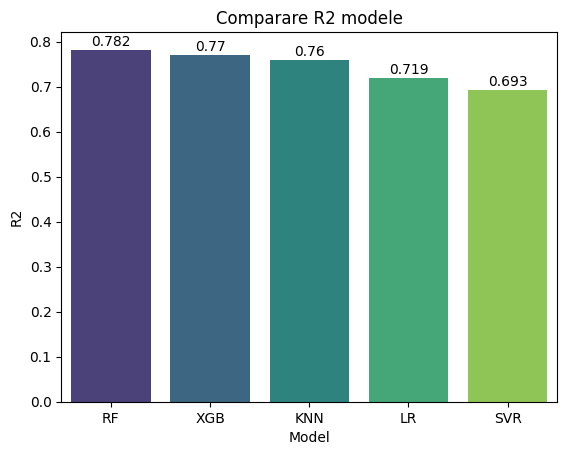

In [ ]:
data_models = {'Model': ['RF', 'XGB', 'KNN', 'LR', 'SVR'], 'R2': [0.782,0.77,0.76,0.719,0.693]}
df_models = pd.DataFrame(data_models)
fig,ax = plt.subplots()
plot = sns.barplot(df_models, x='Model', y = 'R2', palette='viridis')
for p in plot.patches:
    plot.annotate(format(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 6),
                   textcoords = 'offset points')
ax.set_title('Comparare R2 modele')
plt.show()

In [ ]:
r_test_list = []
r_train_list = []
model_name_list=[]

In [ ]:
def fitting(model,scaler_name, model_name):
  pipeline = make_pipeline(scaler_name, model)
  pipeline.fit(X_train, y_train)

  y_pred_log = pipeline.predict(X_test)
  y_pred_train = pipeline.predict(X_train)

  y_pred_org = transformer.inverse_transform(y_pred_log)
  y_pred_train_org = transformer.inverse_transform(y_pred_train)
  y_test_org = transformer.inverse_transform(y_test)
  y_train_org = transformer.inverse_transform(y_train)

  r2_test = round(r2_score(y_test_org, y_pred_org),3)
  r2_train = round(r2_score(y_train_org, y_pred_train_org),3)
  r_test_list.append(r2_test)
  r_train_list.append(r2_train)
  model_name_list.append(model_name)
  print('Test vs Train:',r2_test, r2_train)
  return r_test_list, r_train_list, model_name_list

In [ ]:
res = fitting(LinearRegression(),None,'LR')

Overfitting: 0.719 0.747


In [ ]:
res = fitting(KNeighborsRegressor(n_neighbors = 8), StandardScaler(),'KNN')

Overfitting: 0.76 0.826


In [ ]:
res = fitting(RandomForestRegressor(n_estimators = 500), None,'RF')

Overfitting: 0.782 0.853


In [ ]:
res = fitting(xgb.XGBRegressor(gamma = 1,n_estimators = 5000 ,max_depth = 5, learning_rate = 0.001), None,'XGB')

Overfitting: 0.77 0.776


In [ ]:
res = fitting(SVR(C = 10, kernel = 'linear'), StandardScaler(),'SVR')

Overfitting: 0.693 0.78


In [ ]:
test, train, model_name = res

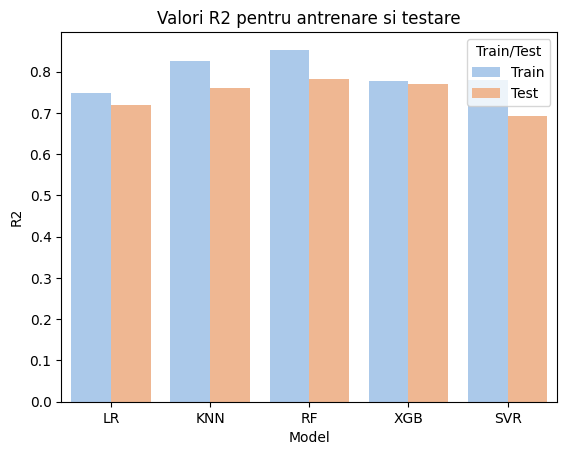

In [ ]:
data_fitting = {'Model': model_name, 'Train': train, 'Test': test}

data_fitting = pd.DataFrame(data_fitting)

data_fitting = data_fitting.melt('Model', var_name='Train/Test', value_name='R2')

sns.barplot(x='Model', y='R2', hue='Train/Test', data=data_fitting, palette = 'pastel')

plt.ylabel('R2')

plt.title('Valori R2 pentru antrenare si testare')
plt.show()

SFS

In [ ]:
def comp_farasfs(model, scaler, model_name, model_to_implement, X_train, y_train, X_test):

    pipeline = make_pipeline(scaler, model_to_implement)

    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()

    y_pred_log = pipeline.predict(X_test)
    y_pred_org = transformer.inverse_transform(y_pred_log)
    y_test_org = transformer.inverse_transform(y_test)

    r2 = round(r2_score(y_test_org, y_pred_org),3)
    rmse_norm = round(np.sqrt(mean_squared_error(y_test_org, y_pred_org))/np.mean(y_test_org),3)
    duration = round(end-start,3)

    model_scores = pd.DataFrame(columns=['Model fără SFS', 'RMSE_norm','R2', 'Timp antrenare'])
    model_scores.loc[len(model_scores)] = [model_name, rmse_norm, r2, duration]
    return model_scores

In [ ]:
all = pd.DataFrame(columns=['Model fără SFS','RMSE_norm', 'R2','Timp antrenare'])

In [ ]:
all = pd.concat([all,comp_farasfs(LinearRegression(),None, 'Linear Regression', LinearRegression(), X_train, y_train, X_test)], ignore_index= True)

In [ ]:
all = pd.concat([all,comp_farasfs(xgb.XGBRegressor(),None, 'Extreme Gradient Boosting Regressor', xgb.XGBRegressor( gamma = 1,n_estimators = 5000 ,max_depth = 5, learning_rate = 0.001), X_train, y_train, X_test)], ignore_index= True)

In [ ]:
all = pd.concat([all,comp_farasfs(RandomForestRegressor(),None, 'Random Forest Regressor',RandomForestRegressor(n_estimators = 500), X_train, y_train, X_test)], ignore_index= True)

In [ ]:
all = pd.concat([all,comp_farasfs(KNeighborsRegressor(),StandardScaler(), 'KNeighbors Regressor', KNeighborsRegressor(n_neighbors = 8), X_train, y_train, X_test)], ignore_index= True)

In [ ]:
all.sort_values(by ='R2',ascending = False).reset_index(drop=True)

,Model fără SFS,RMSE_norm,R2,Timp antrenare
0,Random Forest Regressor,1.125,0.780,24.668
1,Extreme Gradient Boosting Regressor,1.149,0.770,63.607
2,KNeighbors Regressor,1.174,0.760,0.010
3,Linear Regression,1.269,0.719,0.017


In [ ]:
X_train, y_train = data_new[data_new['year'] == 2020].drop('value', axis = 1),data_new[data_new['year']==2020]['value']
X_test, y_test = data_new[data_new['year'] == 2021].drop('value', axis = 1),data_new[data_new['year']==2021]['value']

In [ ]:
def comp_cusfs(number_features, model, scaler, model_name, model_to_implement, X_train, y_train, X_test):

    sfs_model = sfs(model,n_features_to_select=number_features, direction='forward', scoring='r2', cv = TimeSeriesSplit(n_splits = 4))

    sfs_model = sfs_model.fit(X_train, y_train)

    nr = sfs_model.get_support(indices = True)
    features = [name for i, name in enumerate(X_train.columns) if i in nr]
    X_train = X_train[features]
    X_test = X_test[features]

    pipeline = make_pipeline(scaler, model_to_implement)
    start = time.time()
    pipeline.fit(X_train, y_train)
    end = time.time()

    y_pred_log = pipeline.predict(X_test)
    y_pred_org = transformer.inverse_transform(y_pred_log)
    y_test_org = transformer.inverse_transform(y_test)

    r2 = round(r2_score(y_test_org, y_pred_org),3)
    rmse_norm = round(np.sqrt(mean_squared_error(y_test_org, y_pred_org))/np.mean(y_test_org),3)
    duration = round(end-start,3)

    model_scores = pd.DataFrame(columns=['Model cu SFS', 'RMSE_norm','R2', 'Timp antrenare'])
    model_scores.loc[len(model_scores)] = [model_name, rmse_norm, r2, duration]

    print('Cele mai importante trăsături:', features)
    return model_scores

In [ ]:
all = pd.DataFrame(columns=['Model cu SFS','RMSE_norm', 'R2','Timp antrenare'])

In [ ]:
all = pd.concat([all,comp_cusfs(5, LinearRegression(),None, 'Linear Regression', LinearRegression(), X_train, y_train, X_test)], ignore_index= True)

Cele mai importante trăsături: ['order_group_id', 'order_seller', 'store_country_BRA', 'store_country_CHL', 'store_country_MEX']


In [ ]:
all = pd.concat([all,comp_cusfs(5, xgb.XGBRegressor(),None, 'Extreme Gradient Boosting Regressor', xgb.XGBRegressor( gamma = 1,n_estimators = 5000 ,max_depth = 5, learning_rate = 0.001), X_train, y_train, X_test)], ignore_index= True)

Cele mai importante trăsături: ['order_seller', 'account_group', 'is_pandemic', 'unemployment_value', 'store_country_BRA']


In [ ]:
all = pd.concat([all,comp_cusfs(5, RandomForestRegressor(),None, 'Random Forest Regressor',RandomForestRegressor(n_estimators = 500), X_train, y_train, X_test)], ignore_index= True)

Cele mai importante trăsături: ['order_group_id', 'order_seller', 'account_group', 'ppp_value', 'store_country_BRA']


In [ ]:
all = pd.concat([all,comp_cusfs(5, KNeighborsRegressor(),StandardScaler(), 'KNeighbors Regressor', KNeighborsRegressor(n_neighbors = 8), X_train, y_train, X_test)], ignore_index= True)

Cele mai importante trăsături: ['order_group_id', 'tavg', 'ppp_value', 'unemployment_value', 'account_encoded']


In [ ]:
all.sort_values(by = 'R2',ascending = False).reset_index(drop=True)

,Model cu SFS,RMSE_norm,R2,Timp antrenare
0,Random Forest Regressor,1.143,0.772,1.807
1,Extreme Gradient Boosting Regressor,1.231,0.736,16.500
2,KNeighbors Regressor,1.234,0.735,0.010
3,Linear Regression,1.240,0.732,0.005
